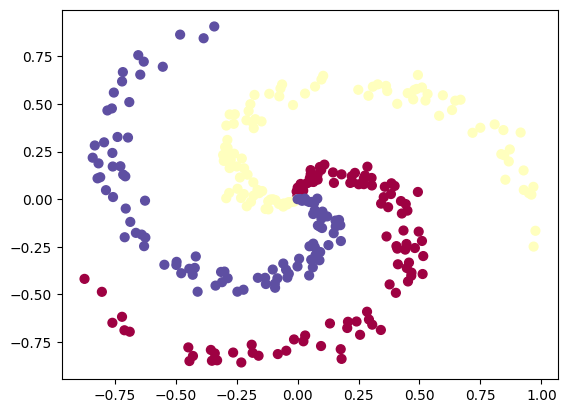

In [1]:
# Generate spiral dataset

import numpy as np
import matplotlib.pyplot as plt

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [14]:
# Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):

    # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    if i % 10 == 0:
        print("iteration %d: loss %f" % (i, loss))

    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters (W,b)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    dW += reg*W # regularization gradient

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db

# Evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('Training accuracy: %.2f' % (np.mean(predicted_class == y)))

iteration 0: loss 1.097244
iteration 10: loss 0.909554
iteration 20: loss 0.839481
iteration 30: loss 0.807466
iteration 40: loss 0.790688
iteration 50: loss 0.781066
iteration 60: loss 0.775196
iteration 70: loss 0.771455
iteration 80: loss 0.768990
iteration 90: loss 0.767326
iteration 100: loss 0.766180
iteration 110: loss 0.765379
iteration 120: loss 0.764812
iteration 130: loss 0.764406
iteration 140: loss 0.764114
iteration 150: loss 0.763901
iteration 160: loss 0.763746
iteration 170: loss 0.763632
iteration 180: loss 0.763548
iteration 190: loss 0.763486
Training accuracy: 0.52


In [15]:
# Train a Neural Network

# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):

    # evaluate class scores, [N x K]
    hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss
    if i % 1000 == 0:
        print("iteration %d: loss %f" % (i, loss))

    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
    # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

# Evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('Training accuracy: %.2f' % (np.mean(predicted_class == y)))

iteration 0: loss 1.098755
iteration 1000: loss 0.321220
iteration 2000: loss 0.266220
iteration 3000: loss 0.254253
iteration 4000: loss 0.249577
iteration 5000: loss 0.246350
iteration 6000: loss 0.245471
iteration 7000: loss 0.244792
iteration 8000: loss 0.244644
iteration 9000: loss 0.244593
Training accuracy: 0.99


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, D, h, K):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(D, h)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(h, K)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNN(D, h, K)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-0, weight_decay=1e-3)  # weight_decay for L2 regularization

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    scores = model(X_tensor)
    
    # Compute the loss
    loss = criterion(scores, y_tensor)
    
    # Print loss every 1000 iterations
    if epoch % 1000 == 0:
        print(f"iteration {epoch}: loss {loss.item():.6f}")
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Update the parameters
    optimizer.step()

# Check prediction accuracy
with torch.no_grad():  # No need to compute gradients for this
    scores = model(X_tensor)
    _, predicted = torch.max(scores, 1)
    accuracy = (predicted == y_tensor).float().mean()
    print(f'Training accuracy: {accuracy:.2f}')

iteration 0: loss 1.096616
iteration 1000: loss 0.120808
iteration 2000: loss 0.112436
iteration 3000: loss 0.111587
iteration 4000: loss 0.111217
iteration 5000: loss 0.110872
iteration 6000: loss 0.110614
iteration 7000: loss 0.110284
iteration 8000: loss 0.110079
iteration 9000: loss 0.109982
Training accuracy: 0.99
